# **TWEET SENTIMENT ANALYSIS**

## Problem
Classify the [tweet sentiment dataset]() (cleaned).

## Initialize

In [1]:
import os
import io
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, GlobalAveragePooling1D, Bidirectional, LSTM, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

# ignore all warning (NOT recommended)
warnings.filterwarnings("ignore")

**Global inputs**

In [3]:
EMBED_DIMS = 100
MAX_LENGTH = 120
TRUNC_TYPE = 'post'
PAD_TYPE = 'post'

TRAIN_SPLIT = 0.8

LOG_DIR = '02-logs'
PROBLEM = 'twitter'

## Dataset
**Get the dataset**

In [4]:
data_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/training_cleaned.csv'
path_out = '../.tmp/training_cleaned.csv'

# download the dataset
if not os.path.exists(path_out):
    os.system(f"""wget --no-check-certificate {data_url} -O {path_out}""")

# read the csv file
df = pd.read_csv(path_out)

df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


**Data preparation**

In [5]:
# extract the columns
sentences = df.iloc[:, 5].to_numpy()
labels = df.iloc[:, 0].to_numpy()

# number of unique labels
class_names = set(labels)

# examine the dataset
print(f'shape - sentences: {sentences.shape}, {labels.shape}')
print(f'unique labels - {class_names}, total: {len(class_names)}')

shape - sentences: (1599999,), (1599999,)
unique labels - {0, 4}, total: 2


**Shuffle and split**

In [6]:
# get randomly shuffled indices
idc = np.arange(len(sentences))
np.random.shuffle(idc)

# shuffle the dataset
sentences = sentences[idc]
labels = labels[idc]

In [7]:
# number of training samples
num_train = int(TRAIN_SPLIT *  len(sentences))

# training subset
train_sentences = sentences[:num_train]
train_labels = labels[:num_train]

# validation subset
validation_sentences = sentences[num_train:]
validation_labels = labels[num_train:]

# check the size
print(f'training samples: {len(train_sentences)}')
print(f'validation samples: {len(validation_sentences)}')

training samples: 1279999
validation samples: 320000


## Pre-processing

**Training data**

In [8]:
# initiate a tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
# update the vocabulary on training texts
tokenizer.fit_on_texts(train_sentences)

# vocabulary
word_index = tokenizer.word_index
vocab_size = len(word_index)

# get sequences
train_sequences = tokenizer.texts_to_sequences(train_sentences)
# padding
train_padded = pad_sequences(train_sequences, padding=PAD_TYPE, maxlen=MAX_LENGTH, truncating=TRUNC_TYPE)

print(train_padded.shape)

(1279999, 120)


**Validation data**

In [9]:
# get sequences
validation_sequences = tokenizer.texts_to_sequences(validation_sentences)
# padding
validation_padded = pad_sequences(validation_sequences, padding=PAD_TYPE, maxlen=MAX_LENGTH, truncating=TRUNC_TYPE)

print(validation_padded.shape)

(320000, 120)


**Labels**

In [10]:
# convert to binary
training_label_seq = np.array(train_labels == 0, int)
validation_label_seq = np.array(validation_labels == 0, int)

# see some example
print(training_label_seq[:5], '...', training_label_seq.shape)

[0 0 1 0 0] ... (1279999,)


## Pre-trained Embeddings

**GloVe**
([See more](https://nlp.stanford.edu/projects/glove/))


In [11]:
data_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt'
path_out = '../.tmp/glove.6B.100d.txt'
save_mat = LOG_DIR + '/' + PROBLEM + '-glove_embedding.npy'

# download the dataset
if not os.path.exists(path_out):
    os.system(f"""wget --no-check-certificate {data_url} -O {path_out}""")

if os.path.exists(save_mat):
    embeddings_matrix = np.load(save_mat)
else:
    embeddings_index = {}
    with open(path_out, 'r', encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embeddings_matrix = np.zeros((vocab_size+1, EMBED_DIMS))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embeddings_matrix[i] = embedding_vector

    np.save(save_mat, embeddings_matrix)

# pre-trained embeddings
print(embeddings_matrix.shape)

(594792, 100)


## Model

In [12]:
# input layer
input_tensor = Input(shape=MAX_LENGTH)

# pre-trained embedding layer
x = Embedding(
    input_dim=embeddings_matrix.shape[0],
    output_dim=embeddings_matrix.shape[1],
    input_length=MAX_LENGTH,
    weights=[embeddings_matrix],
    trainable=False
)(input_tensor)

# hidden layers
x = Dropout(0.2)(x)
x = Conv1D(64, 5, activation='relu')(x)
x = MaxPooling1D(pool_size=4)(x)
x = LSTM(64)(x)

# output layer
output_tensor = Dense(1, activation='sigmoid')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 120)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 120, 100)          59479200  
_________________________________________________________________
dropout (Dropout)            (None, 120, 100)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 116, 64)           32064     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 29, 64)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65    

## Train

**Callbacks**

In [13]:
# reduce learning rate
reduce_rl = ReduceLROnPlateau(
    monitor='val_acc', mode='max', factor=0.1, patience=3, verbose=2
)

# stop training
early_stopping = EarlyStopping(
    monitor='val_acc',  mode='max', min_delta=0, patience=10, verbose=2, restore_best_weights=True
)

**Start Training**

In [14]:
# train the model
hist = model.fit(
    train_padded, training_label_seq,
    batch_size=10_000,
    validation_data=(validation_padded, validation_label_seq),
    epochs=50,
    verbose=1,
    callbacks=[reduce_rl, early_stopping]
)

Train on 1279999 samples, validate on 320000 samples
Epoch 1/50
1279999/1279999 [==============================] - 66s 52us/sample - loss: 0.5948 - acc: 0.6732 - val_loss: 0.5203 - val_acc: 0.7394
Epoch 2/50
1279999/1279999 [==============================] - 56s 43us/sample - loss: 0.5270 - acc: 0.7337 - val_loss: 0.4959 - val_acc: 0.7565
Epoch 3/50
1279999/1279999 [==============================] - 56s 44us/sample - loss: 0.5089 - acc: 0.7471 - val_loss: 0.4914 - val_acc: 0.7591
Epoch 4/50
1279999/1279999 [==============================] - 51s 40us/sample - loss: 0.4978 - acc: 0.7549 - val_loss: 0.4789 - val_acc: 0.7680
Epoch 5/50
1279999/1279999 [==============================] - 51s 40us/sample - loss: 0.4913 - acc: 0.7595 - val_loss: 0.4698 - val_acc: 0.7746
Epoch 6/50
1279999/1279999 [==============================] - 51s 40us/sample - loss: 0.4855 - acc: 0.7637 - val_loss: 0.4658 - val_acc: 0.7767
Epoch 7/50
1279999/1279999 [==============================] - 51s 40us/sample - los

**Show training graphs**

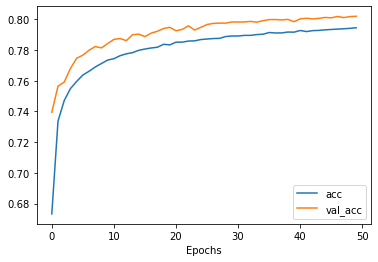

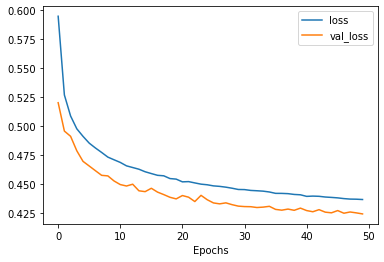

In [15]:
def plot_graphs(history, metrics):
    plt.figure()
    for metric in metrics:
        plt.plot(history.history[metric], label=metric)
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

plot_graphs(hist, ["acc", "val_acc"])
plot_graphs(hist, ["loss", "val_loss"])

## Save Learned Embeddings

**Vector and metadata**

In [16]:
# index to word dictionary
reverse_word_index = dict([(value, key) for (key, value) in tokenizer.word_index.items()])

# get the weights in the embedding layers
weights = model.layers[1].get_weights()[0]

out_v = io.open(LOG_DIR + '/' + PROBLEM + '-vecs.tsv', 'w', encoding='utf-8')
out_m = io.open(LOG_DIR + '/' + PROBLEM + '-meta.tsv', 'w', encoding='utf-8')

for word_num in range(1, vocab_size):
    word = reverse_word_index[word_num]
    embeddings = weights[word_num]
    out_m.write(word + "\n")
    out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")

out_v.close()
out_m.close()

**Visualize**
- Go to [tensorflor embedding projector](http://projector.tensorflow.org/).
- Upload the `vecs.tsv` and `meta.tsv` files and see the embeddings.